In [1]:
%matplotlib inline

In [2]:
from scipy import stats as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import warnings
warnings.filterwarnings('ignore')

sns.set_context("poster")

In [3]:
### This is the same as the p1 version but doing the manipulation on all the data

In [4]:
train = pd.read_csv('data/train.csv')
train['event_id'] = [x for x in xrange(len(train))]
train[['event_id','hotel_cluster']].to_csv('data/train_full_y.csv',index=False)

KeyboardInterrupt: 

In [ ]:
test = pd.read_csv('data/test.csv')
test['train_flag'] = 0
train.drop(['event_id','hotel_cluster'],1,inplace=True)
train['train_flag'] = 1

print test.columns
print train.columns

In [ ]:
all_data = train.append(test)

In [34]:
train_x = pd.read_csv('data/train_sample_x.csv')
train_x.columns

Index([u'date_time', u'site_name', u'posa_continent', u'user_location_country',
       u'user_location_region', u'user_location_city',
       u'orig_destination_distance', u'user_id', u'is_mobile', u'is_package',
       u'channel', u'srch_ci', u'srch_co', u'srch_adults_cnt',
       u'srch_children_cnt', u'srch_rm_cnt', u'srch_destination_id',
       u'srch_destination_type_id', u'is_booking', u'cnt', u'hotel_continent',
       u'hotel_country', u'hotel_market', u'event_id'],
      dtype='object')

What do we want to check?
- data type
- no. uniques
- null values

In [19]:
def desc_df(dataf):
    lentrain = len(dataf)
    outp = []
    for i, j in train_x.dtypes.iteritems():
        outp.append([i, j, float(len(dataf[i].dropna()))/lentrain, len(dataf[i].unique())])

    return pd.DataFrame(outp,columns = ['variable','type','% non null','unique values'])

In [20]:
outp = desc_df(train_x)
outp

variable     type  % non null  unique values
0                   date_time   object    1.000000         187932
1                   site_name    int64    1.000000             42
2              posa_continent    int64    1.000000              5
3       user_location_country    int64    1.000000            209
4        user_location_region    int64    1.000000            821
5          user_location_city    int64    1.000000          14402
6   orig_destination_distance  float64    0.640018         115059
7                     user_id    int64    1.000000         153626
8                   is_mobile    int64    1.000000              2
9                  is_package    int64    1.000000              2
10                    channel    int64    1.000000             11
11                    srch_ci   object    0.998545           1088
12                    srch_co   object    0.998545           1093
13            srch_adults_cnt    int64    1.000000             10
14          srch_children_cnt    int64    1.000000             10
15                srch_rm_cnt    int64    1.000000              9
16        srch_destination_id    int64    1.000000          11824
17   srch_destination_type_id    int64    1.000000              8
18                 is_booking    int64    1.000000              2
19                        cnt    int64    1.000000             31
20            hotel_continent    int64    1.000000              7
21              hotel_country    int64    1.000000            181
22               hotel_market    int64    1.000000           1954
23                   event_id    int64    1.000000         188351

### Visualising integer variables

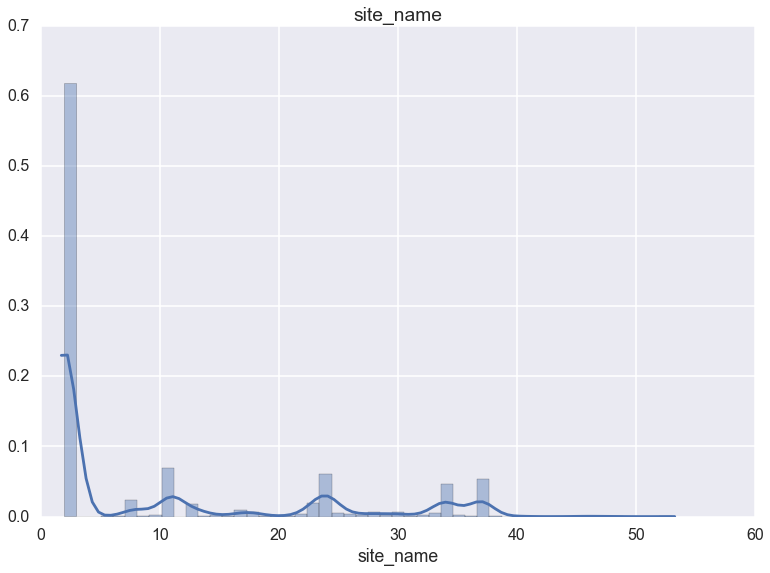

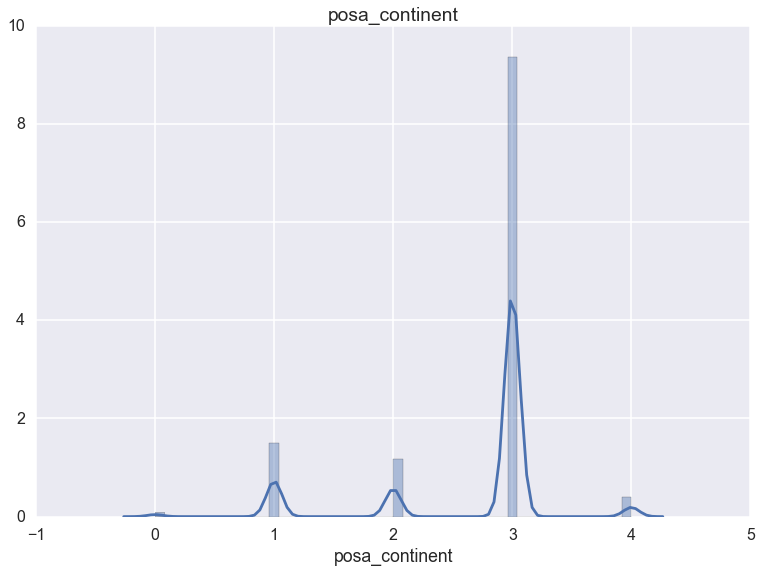

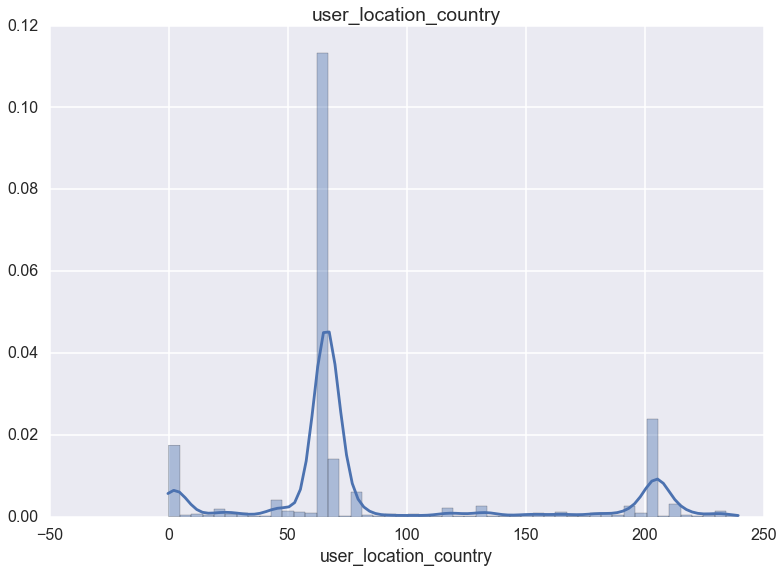

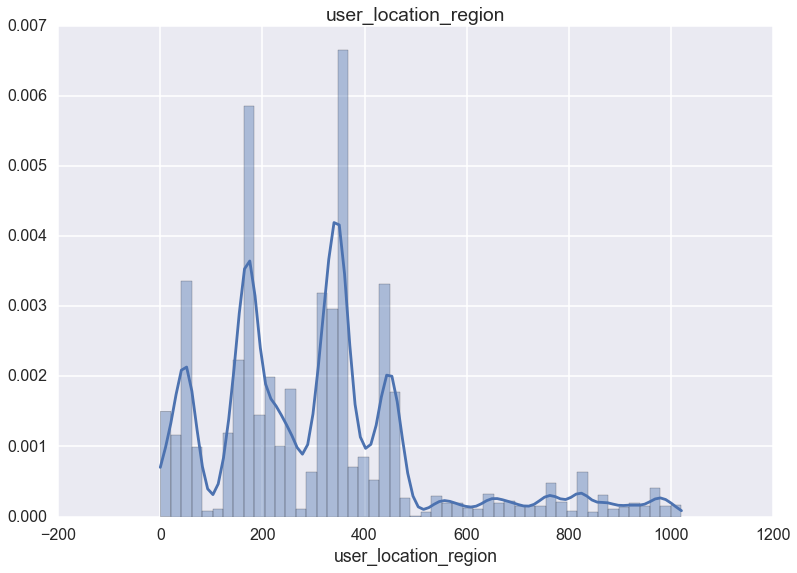

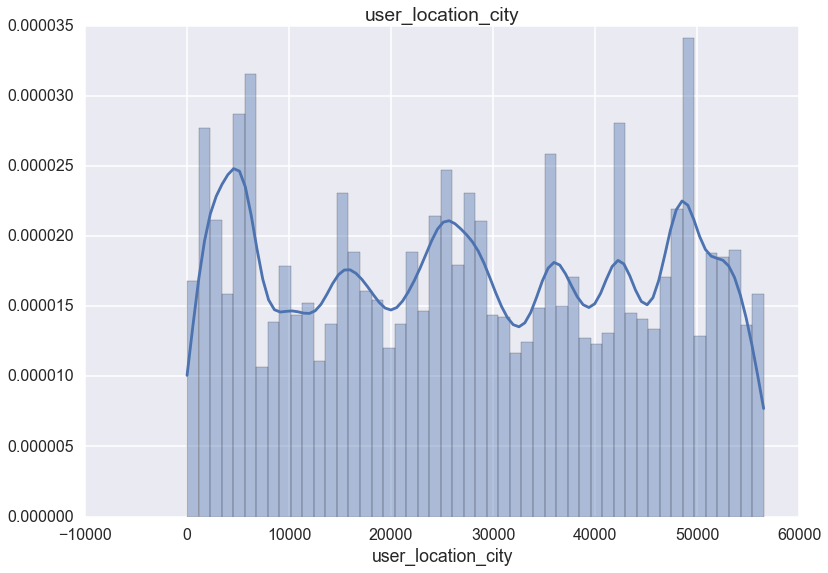

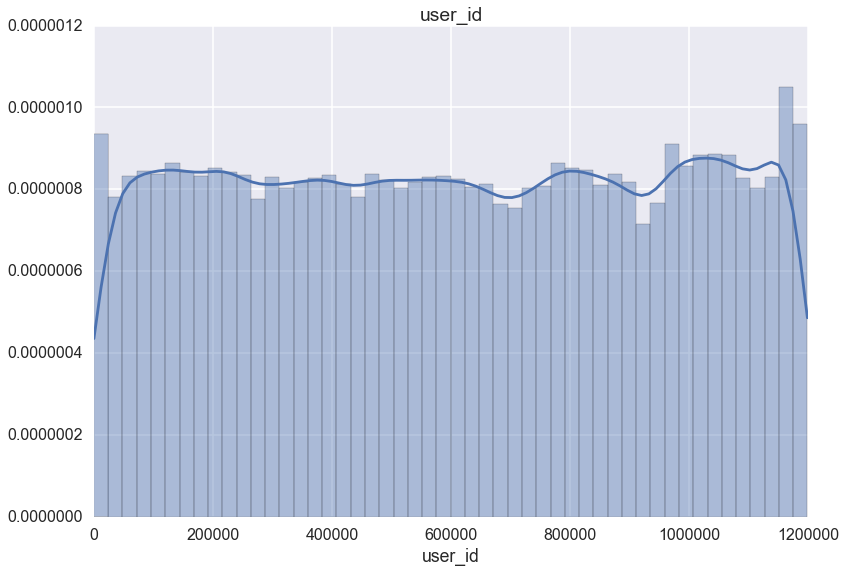

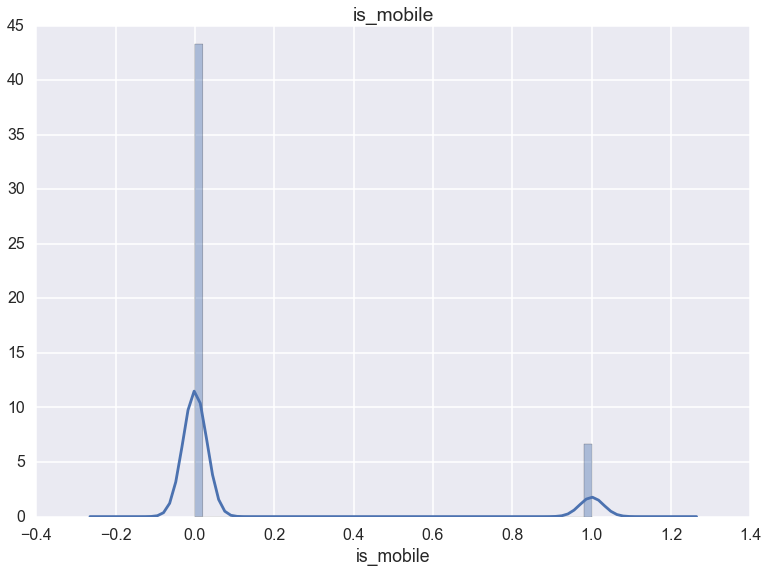

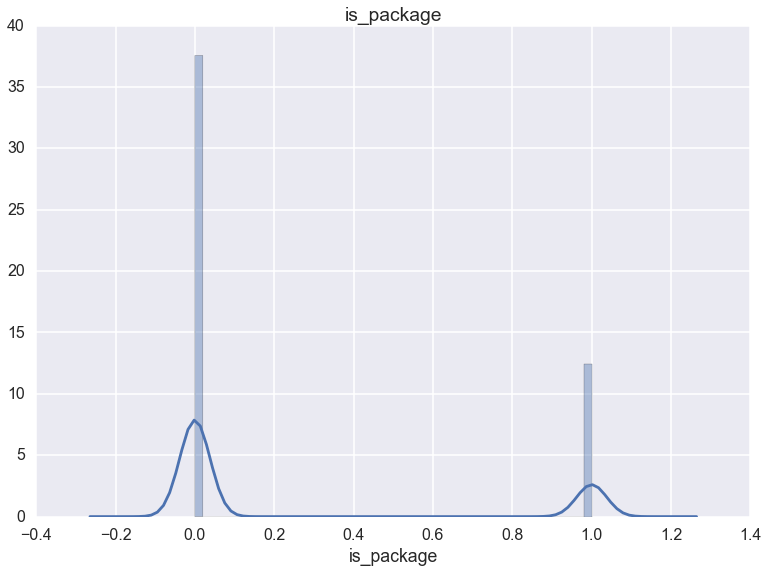

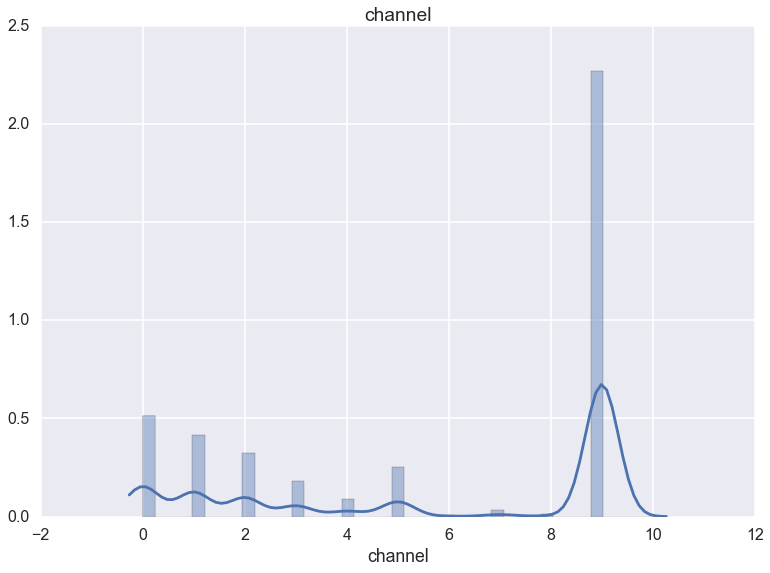

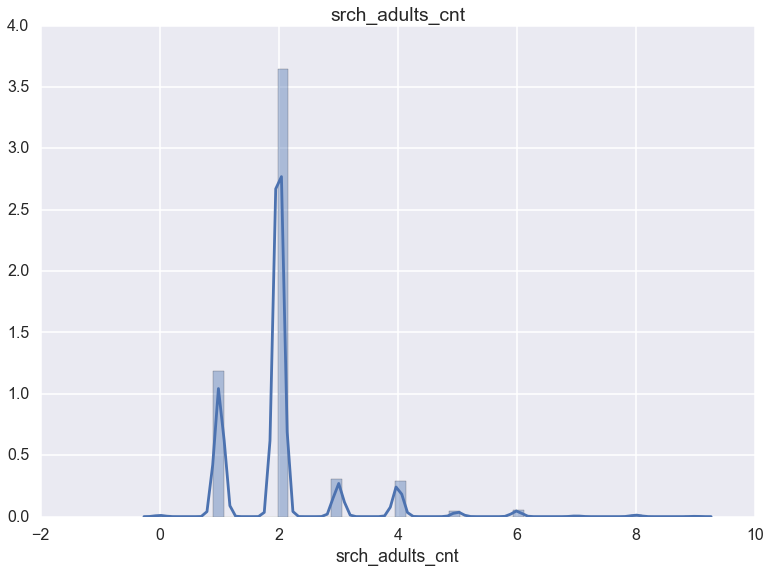

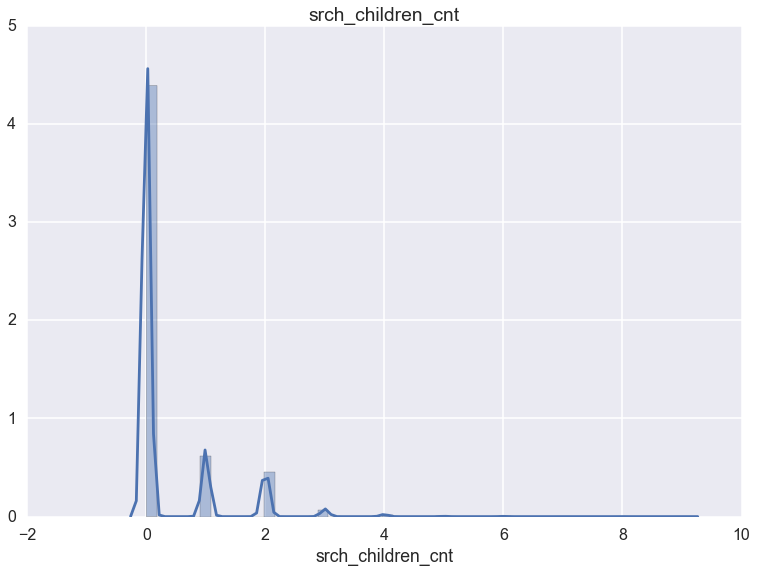

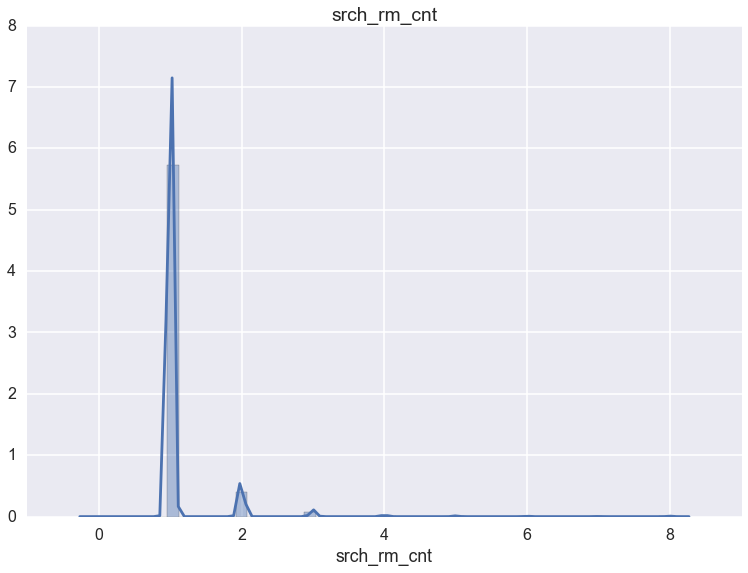

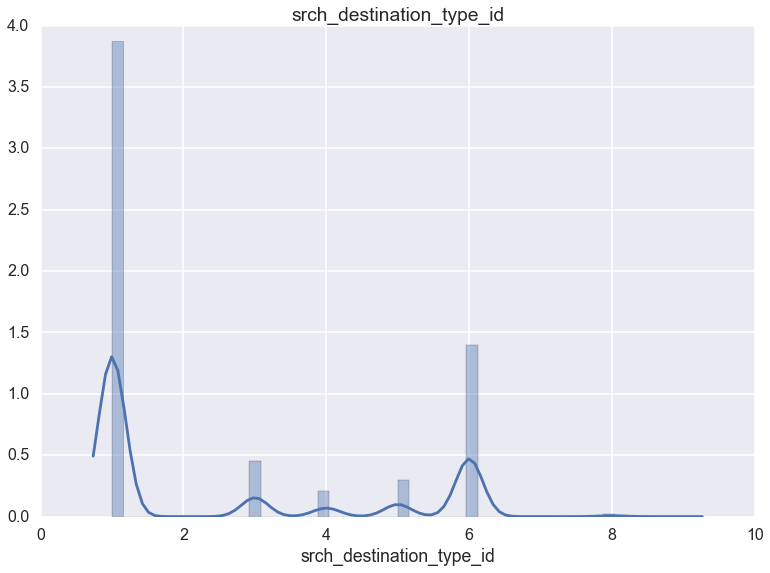

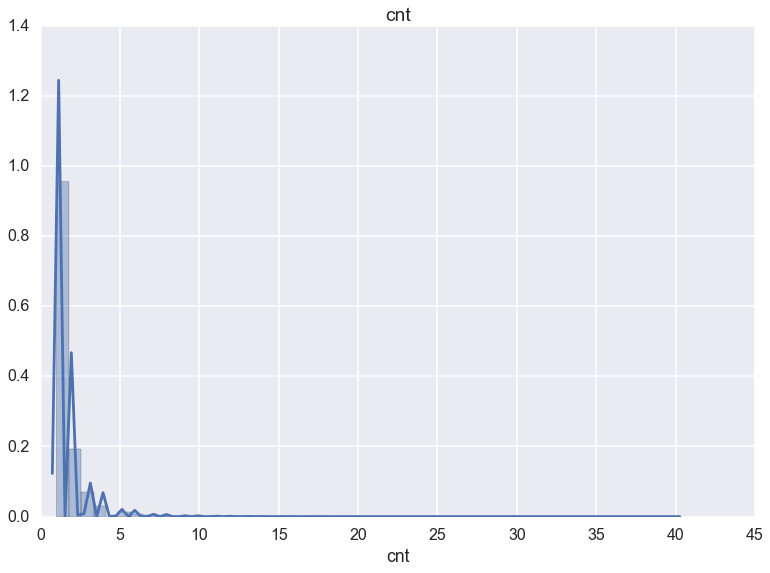

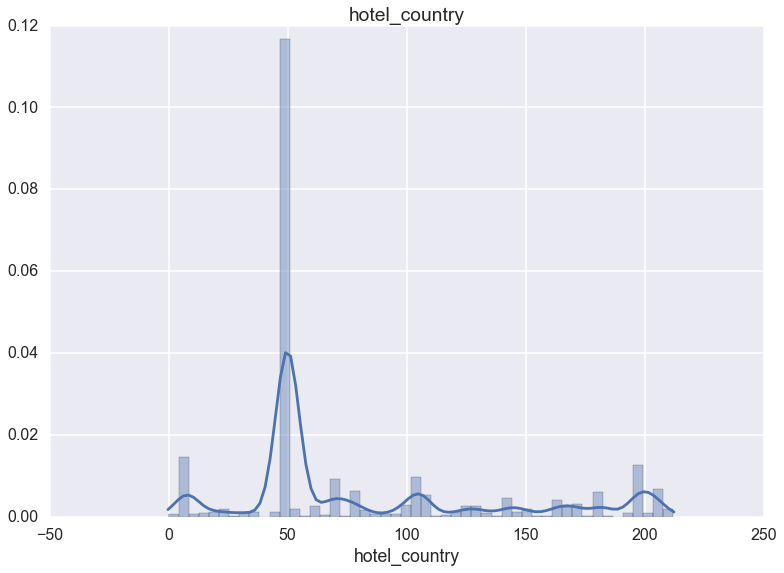

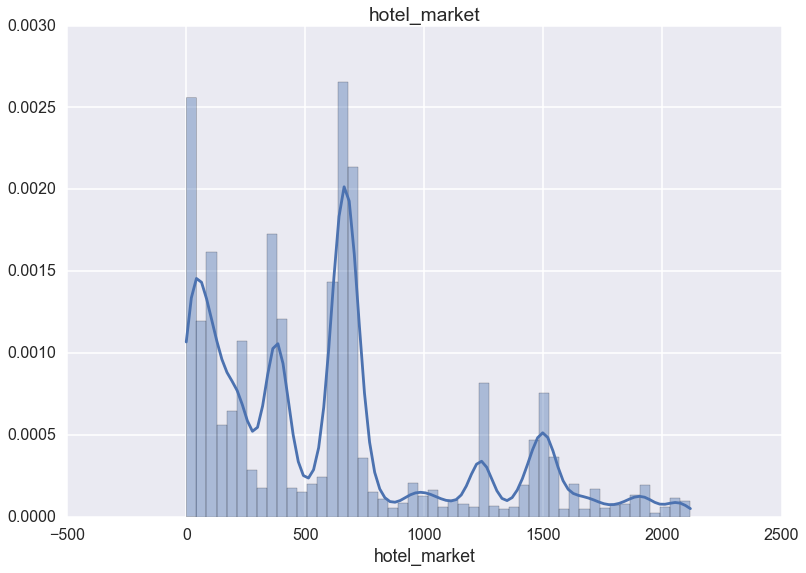

In [21]:
for col in outp[outp['type']=='int64']['variable']:
    sns.distplot(train_x[col])
    plt.title(col)
    plt.show()

In [12]:
train_x[['date_time','srch_ci','srch_co','orig_destination_distance']].head()

date_time     srch_ci     srch_co  orig_destination_distance
0  2013-12-07 19:15:25  2014-04-15  2014-04-20                  1587.4944
1  2014-07-29 06:17:44  2014-08-25  2014-08-27                  8944.0817
2  2014-11-11 17:06:43  2014-11-26  2014-11-29                   872.7534
3  2014-10-02 13:51:10  2014-10-04  2014-10-05                    10.4244
4  2014-07-18 14:44:03  2014-10-24  2014-10-27                  6372.7824

Looks like for the data manipulation we need to:

* binarize the 'int64' variables
* Create new date variables for the date_times (this will also deal with any null values)
* Keep orig_destination_distance and cnt as is - need to deal with null values
    * Potentially we create bands and all 0's in band deals with null values

In [22]:
def manip(x):
    if x['unique values'] == 2:
        return 'bool'
    if x['variable'] in ['user_id','srch_destination_id','event_id']:
        return 'id'
    if x['type'] == 'int64' and x['variable'] != 'cnt':
        return 'cat'
    if x['variable'] in ['cnt','orig_destination_distance']:
        return 'con'
    if x['variable'] == 'date_time':
        return 'datetime'
    if x['variable'] in ['srch_ci','srch_co']:
        return 'date'

outp['manip_type'] = outp.apply(lambda x: manip(x),1)

In [23]:
outp

variable     type  % non null  unique values manip_type
0                   date_time   object    1.000000         187932   datetime
1                   site_name    int64    1.000000             42        cat
2              posa_continent    int64    1.000000              5        cat
3       user_location_country    int64    1.000000            209        cat
4        user_location_region    int64    1.000000            821        cat
5          user_location_city    int64    1.000000          14402        cat
6   orig_destination_distance  float64    0.640018         115059        con
7                     user_id    int64    1.000000         153626         id
8                   is_mobile    int64    1.000000              2       bool
9                  is_package    int64    1.000000              2       bool
10                    channel    int64    1.000000             11        cat
11                    srch_ci   object    0.998545           1088       date
12                    srch_co   object    0.998545           1093       date
13            srch_adults_cnt    int64    1.000000             10        cat
14          srch_children_cnt    int64    1.000000             10        cat
15                srch_rm_cnt    int64    1.000000              9        cat
16        srch_destination_id    int64    1.000000          11824         id
17   srch_destination_type_id    int64    1.000000              8        cat
18                 is_booking    int64    1.000000              2       bool
19                        cnt    int64    1.000000             31        con
20            hotel_continent    int64    1.000000              7        cat
21              hotel_country    int64    1.000000            181        cat
22               hotel_market    int64    1.000000           1954        cat
23                   event_id    int64    1.000000         188351         id

### Data manipulation - Creating the final dataset

I need a function that takes each categorization and does something to the data
* cat - binarise the data
* con - as is
* bool - as is
* date - take out date parts and binarize
* datetime - as above with more date parts

Lets build some binarize function to help us - keeping it in pandas rather than using base sklearn

Now lets look at the dates to create categorical variables and then binarise everything together

For dates we want:

* day
* week of year
* day of week
* month
* year

For datetimes we additinally want:

* hour
* am/pm

In [24]:
from datetime import datetime, date
import math

def date_parts_df(data,variable,iid='event_id',dformat='%Y-%m-%d'):
    new_df = data[[iid,variable]]

    new_df[variable+'_year'] = new_df[variable].apply(
        lambda x: datetime.strptime(x,dformat).year if pd.notnull(x) else None
    )

    new_df[variable+'_day'] = new_df[variable].apply(
        lambda x: datetime.strptime(x,dformat).day if pd.notnull(x) else None
    )

    new_df[variable+'_month'] = new_df[variable].apply(
        lambda x: datetime.strptime(x,dformat).month if pd.notnull(x) else None
    )

    new_df[variable+'_dayofweek'] = new_df[variable].apply(
        lambda x: datetime.strptime(x,dformat).weekday() if pd.notnull(x) else None
    )

    new_df[variable+'_yearquarter'] = new_df[variable].apply(
        lambda x: (datetime.strptime(x,dformat).toordinal() - date(datetime.strptime(x,dformat).year, 1, 1).toordinal() + 1)*4/365 if pd.notnull(x) else None
    )

    return new_df.drop(variable,1)

def datetime_parts_df(data,variable,iid='user_id',dformat='%Y-%m-%d %H:%M:%S'):
    new_df = date_parts_df(data,variable,iid,dformat=dformat)
    
    new_df[variable+'_hour'] = data[variable].apply(
        lambda x: datetime.strptime(x,dformat).hour if pd.notnull(x) else None
    )
    
    return new_df

Order of manipulation:

* Change date and datetime fields
* merge to categorical fields
* create all as categroical fields
* merge to boolean and continuous

In [25]:
##Get all date parts for dates and datetimes
i=0
for var in outp[outp['manip_type']=='date']['variable']:
    if i==0:
        dates_df = date_parts_df(train_x,var,iid='event_id')
        i+=1
    else:
        df2 = date_parts_df(train_x,var,iid='event_id')
#        print dates_df.head()
#        print df2.head()
        dates_df = pd.merge(dates_df,df2,on='event_id')

for var in outp[outp['manip_type']=='datetime']['variable']:
    df2 = datetime_parts_df(train_x,var,iid='event_id')
    dates_df = pd.merge(dates_df,df2,on='event_id')

print dates_df.head()

   event_id  srch_ci_year  srch_ci_day  srch_ci_month  srch_ci_dayofweek  \
0         0        2014.0         15.0            4.0                1.0   
1         1        2014.0         25.0            8.0                0.0   
2         2        2014.0         26.0           11.0                2.0   
3         3        2014.0          4.0           10.0                5.0   
4         4        2014.0         24.0           10.0                4.0   

   srch_ci_yearquarter  srch_co_year  srch_co_day  srch_co_month  \
0                  1.0        2014.0         20.0            4.0   
1                  2.0        2014.0         27.0            8.0   
2                  3.0        2014.0         29.0           11.0   
3                  3.0        2014.0          5.0           10.0   
4                  3.0        2014.0         27.0           10.0   

   srch_co_dayofweek  srch_co_yearquarter  date_time_year  date_time_day  \
0                6.0                  1.0            2013 

In [26]:
###Append all categorical variables
cat_df = train_x[['event_id']+outp[outp['manip_type']=='cat']['variable'].tolist()]

full_cat_df = pd.merge(dates_df,cat_df,on='event_id')

In [27]:
full_cat_df.head()

event_id  srch_ci_year  srch_ci_day  srch_ci_month  srch_ci_dayofweek  \
0         0        2014.0         15.0            4.0                1.0   
1         1        2014.0         25.0            8.0                0.0   
2         2        2014.0         26.0           11.0                2.0   
3         3        2014.0          4.0           10.0                5.0   
4         4        2014.0         24.0           10.0                4.0   

   srch_ci_yearquarter  srch_co_year  srch_co_day  srch_co_month  \
0                  1.0        2014.0         20.0            4.0   
1                  2.0        2014.0         27.0            8.0   
2                  3.0        2014.0         29.0           11.0   
3                  3.0        2014.0          5.0           10.0   
4                  3.0        2014.0         27.0           10.0   

   srch_co_dayofweek      ...       user_location_region  user_location_city  \
0                6.0      ...                        348               47997   
1                2.0      ...                        351               52368   
2                5.0      ...                        462               52482   
3                6.0      ...                        174               53078   
4                0.0      ...                        174               41942   

   channel  srch_adults_cnt  srch_children_cnt  srch_rm_cnt  \
0        9                2                  2            1   
1        9                2                  0            1   
2        0                2                  0            1   
3        9                2                  0            1   
4        9                2                  0            1   

   srch_destination_type_id  hotel_continent  hotel_country  hotel_market  
0                         6                4              8           126  
1                         1                3            182          1493  
2                         1                2             50           628  
3                         1                2             50           358  
4                         1                6            105            29  

[5 rows x 30 columns]

In [28]:
##Add back ids from original data
full_cat_df = pd.merge(
    train_x[outp[outp['manip_type']=='id']['variable'].tolist()],
    full_cat_df,
    on='event_id'
    )

In [29]:
full_cat_df.head()

user_id  srch_destination_id  event_id  srch_ci_year  srch_ci_day  \
0  1091923                 5405         0        2014.0         15.0   
1   643476                 1725         1        2014.0         25.0   
2   760131                 8250         2        2014.0         26.0   
3   631386                11359         3        2014.0          4.0   
4   166207                 8746         4        2014.0         24.0   

   srch_ci_month  srch_ci_dayofweek  srch_ci_yearquarter  srch_co_year  \
0            4.0                1.0                  1.0        2014.0   
1            8.0                0.0                  2.0        2014.0   
2           11.0                2.0                  3.0        2014.0   
3           10.0                5.0                  3.0        2014.0   
4           10.0                4.0                  3.0        2014.0   

   srch_co_day      ...       user_location_region  user_location_city  \
0         20.0      ...                        348               47997   
1         27.0      ...                        351               52368   
2         29.0      ...                        462               52482   
3          5.0      ...                        174               53078   
4         27.0      ...                        174               41942   

   channel  srch_adults_cnt  srch_children_cnt  srch_rm_cnt  \
0        9                2                  2            1   
1        9                2                  0            1   
2        0                2                  0            1   
3        9                2                  0            1   
4        9                2                  0            1   

   srch_destination_type_id  hotel_continent  hotel_country  hotel_market  
0                         6                4              8           126  
1                         1                3            182          1493  
2                         1                2             50           628  
3                         1                2             50           358  
4                         1                6            105            29  

[5 rows x 32 columns]

In [30]:
### Save final file
full_cat_df.to_csv('data/full_cat_df.csv')

### Next steps - Flag for categorical variables
### Run a quick algorithm to see whats going on
## Thoughts
# Do I need a 1/0 classification problem for each hotel cluster and then create a cut-off?
# Do I just need to make 1 and take top five?
# Start with a simple multinomial regression - kind of takes care of both, then think of others
# random forest make work as ech branch will give probabilities for all types

## Workings (ignore)

In [18]:
from sklearn import preprocessing

lb = preprocessing.LabelBinarizer()
lb.fit(full_cat_df['srch_ci_year'])
pd.DataFrame(lb.transform(full_cat_df['srch_ci_year']),columns = ['srch_ci_year'+'_'+str(x) for x in lb.classes_]).head()


def create_binary_var_df(data,variable):
    lb = preprocessing.LabelBinarizer()
    lb.fit(data[variable])
    return pd.DataFrame(lb.transform(data[variable]),columns = [variable+'_'+str(x) for x in lb.classes_])

create_binary_var_df(full_cat_df,'srch_ci_year')

ValueError: Unknown label type: (0          2014.0
1          2014.0
2          2014.0
3          2014.0
4          2014.0
5          2014.0
6          2014.0
7          2014.0
8          2014.0
9          2014.0
10         2014.0
11         2014.0
12         2014.0
13         2014.0
14         2014.0
15         2014.0
16         2014.0
17         2014.0
18         2014.0
19         2014.0
20         2014.0
21         2014.0
22         2014.0
23         2014.0
24         2014.0
25         2014.0
26         2014.0
27         2014.0
28         2014.0
29         2014.0
            ...  
1392527    2014.0
1392528    2014.0
1392529    2014.0
1392530    2014.0
1392531    2014.0
1392532    2014.0
1392533    2014.0
1392534    2014.0
1392535    2014.0
1392536    2013.0
1392537    2013.0
1392538    2014.0
1392539    2015.0
1392540    2014.0
1392541    2014.0
1392542    2013.0
1392543    2013.0
1392544    2014.0
1392545    2014.0
1392546    2014.0
1392547    2013.0
1392548    2014.0
1392549    2014.0
1392550    2013.0
1392551    2013.0
1392552    2015.0
1392553    2014.0
1392554    2014.0
1392555    2013.0
1392556    2014.0
Name: srch_ci_year, dtype: float64,)

In [43]:
from sklearn import preprocessing

def create_binary_var_df(data,variable):
    lb = preprocessing.LabelBinarizer()
    lb.fit(data[variable])
    return pd.DataFrame(lb.transform(data[variable]),columns = [variable+'_'+str(x) for x in lb.classes_])

def create_binary_df(data,iid,variables):
    i=0
    for var in variables:
        if i==0:
            df1 = create_binary_var_df(data,var)
            df1[iid] = data[iid]
            i+=1
        else:
            df2 = create_binary_var_df(data,var)
            df2[iid] = data[iid]
            df1 = pd.merge(df1,df2,on=iid)
    return df1